In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.layers import Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
#Data Paths
train_dir = './data/dog-breed/train'
test_dir = './data/dog-breed/test'

In [3]:
#Read train labels.
labels = pd.read_csv('./data/dog-breed/labels.csv')
#Read sample_submission file to be modified by pridected labels.
sample_df = pd.read_csv('./data/dog-breed/sample_submission.csv')
#Incpect labels_dataframe.
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
#Create list of all the dog breeds
dog_breeds = sorted(list(set(labels['breed'])))
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds[:10]

120


['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle']

In [5]:
#Create a dictionary to map 
class_to_num = dict(zip(dog_breeds, range(n_classes)))

In [6]:
class_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [7]:
def create_data(data_dir, labels_dataframe, img_size = (224,224,3),test_d = False, train_d = False):
    if train_d == True:
        dog_id = labels_dataframe['id']
        dog_labels = labels_dataframe['breed']
        data_size = len(dog_id)
        #Initailize empty output arrays
        X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
        y = np.zeros([data_size,1], dtype=np.uint8)
        #Read data and lables
        for i in tqdm(range(data_size)):
            img_name = dog_id[i]
            img_dir = os.path.join(data_dir, img_name+'.jpg')
            img_pixels = img_to_array(load_img(img_dir, target_size=img_size))
            X[i] = img_pixels

            image_breed = dog_labels[i]
            y[i] = class_to_num[image_breed]

        #One hot encoder
        y = to_categorical(y)
        #shuffle    
        ind = np.random.permutation(data_size)
        X = X[ind]
        y = y[ind]
        print('Ouptut Data Size: ', X.shape)
        print('Ouptut Label Size: ', y.shape)
        return X, y
    
    if test_d == True:
        images_names = labels_dataframe['id']
        data_size = len(images_names)
        X = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
        for i in tqdm(range(data_size)):
            image_name = images_names[i]
            img_dir = os.path.join(data_dir, image_name+'.jpg')
            img_pixels = tf.keras.preprocessing.image.load_img(img_dir, target_size=img_size)
            X[i] = img_pixels
        
    print('Ouptut Data Size: ', X.shape)
    return X

In [8]:
#img_size chosen to be 331 to suit the used architectures.
img_size = (331,331,3)
X, y = create_data(train_dir, labels, img_size, train_d = True)

100%|███████████████████████████████████████████████████████████████████████████| 10222/10222 [00:39<00:00, 261.42it/s]


Ouptut Data Size:  (10222, 331, 331, 3)
Ouptut Label Size:  (10222, 120)


In [9]:
X

array([[[[216, 182, 173],
         [216, 182, 173],
         [217, 180, 172],
         ...,
         [141, 121, 146],
         [141, 121, 146],
         [141, 121, 146]],

        [[212, 172, 164],
         [212, 172, 164],
         [209, 169, 161],
         ...,
         [141, 121, 146],
         [141, 121, 146],
         [141, 121, 146]],

        [[186, 136, 125],
         [186, 136, 125],
         [187, 135, 124],
         ...,
         [138, 119, 141],
         [138, 118, 143],
         [138, 118, 143]],

        ...,

        [[184, 162, 102],
         [184, 162, 102],
         [186, 164, 104],
         ...,
         [236, 218, 154],
         [238, 219, 153],
         [238, 219, 153]],

        [[201, 179, 121],
         [201, 179, 121],
         [200, 178, 120],
         ...,
         [232, 215, 145],
         [234, 216, 144],
         [234, 216, 144]],

        [[210, 190, 129],
         [210, 190, 129],
         [201, 181, 118],
         ...,
         [226, 211, 128],
        

In [10]:
X.shape

(10222, 331, 331, 3)

In [11]:
y.shape

(10222, 120)

In [12]:
def get_features(model_name, data_preprocessor, input_size, data):
    
    #Prepare pipeline using functional API
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', 
                            include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature maps
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [13]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

160/160 [==============================] - 105s 654ms/step
Feature maps shape:  (10222, 2048)


In [14]:
from keras.applications.resnet import ResNet101, preprocess_input
res101_preprocessor = preprocess_input
res101_features = get_features(ResNet101,
                                 res101_preprocessor,
                                 img_size, X)

160/160 [==============================] - 267s 2s/step
Feature maps shape:  (10222, 2048)


In [15]:
#Concatenate feature maps from both extractions
final_features = np.concatenate([inception_features,
                                 res101_features], axis=-1)
print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 4096)


In [16]:
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience = 10,
                          restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose = 1,
                                            factor = 0.1,
                                            min_lr = 0.00001)
callbacks = [earlystop, lr_reduction]

In [17]:
#Prepare the head model
head = tf.keras.models.Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')])

head.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h = head.fit(final_features, y,
            batch_size=128,
            epochs=60,
            validation_split=0.1,
            callbacks=callbacks)

Epoch 1/60
72/72 [==============================] - 1s 11ms/step - loss: 2.4623 - accuracy: 0.4661 - val_loss: 0.6079 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 2/60
72/72 [==============================] - 1s 8ms/step - loss: 0.5992 - accuracy: 0.8414 - val_loss: 0.4028 - val_accuracy: 0.8847 - lr: 0.0010
Epoch 3/60
72/72 [==============================] - 1s 8ms/step - loss: 0.3972 - accuracy: 0.8863 - val_loss: 0.3431 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 4/60
72/72 [==============================] - 1s 8ms/step - loss: 0.3108 - accuracy: 0.9068 - val_loss: 0.3487 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 5/60
70/72 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.9228
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
72/72 [==============================] - 1s 9ms/step - loss: 0.2593 - accuracy: 0.9228 - val_loss: 0.3193 - val_accuracy: 0.8827 - lr: 0.0010
Epoch 6/60
72/72 [==============================] - 1s 8ms/step - loss

In [18]:
test_data = create_data(test_dir, sample_df, img_size, test_d = True)

100%|███████████████████████████████████████████████████████████████████████████| 10357/10357 [01:38<00:00, 105.24it/s]


Ouptut Data Size:  (10357, 331, 331, 3)


In [19]:
#Extract test data features.
inception_features = get_features(InceptionV3, inception_preprocessor, img_size, test_data)

res101_features = get_features(ResNet101, res101_preprocessor, img_size, test_data)

test_features = np.concatenate([inception_features,
                                 res101_features],axis=-1)
print('Final feature maps shape', test_features.shape)

162/162 [==============================] - 113s 697ms/step
Feature maps shape:  (10357, 2048)
162/162 [==============================] - 281s 2s/step
Feature maps shape:  (10357, 2048)
Final feature maps shape (10357, 4096)


In [20]:
y_pred = head.predict(test_features, batch_size=128)

In [21]:
y_pred.shape

(10357, 120)

In [22]:
dog_breeds[np.argmax(y_pred[0])]

'japanese_spaniel'

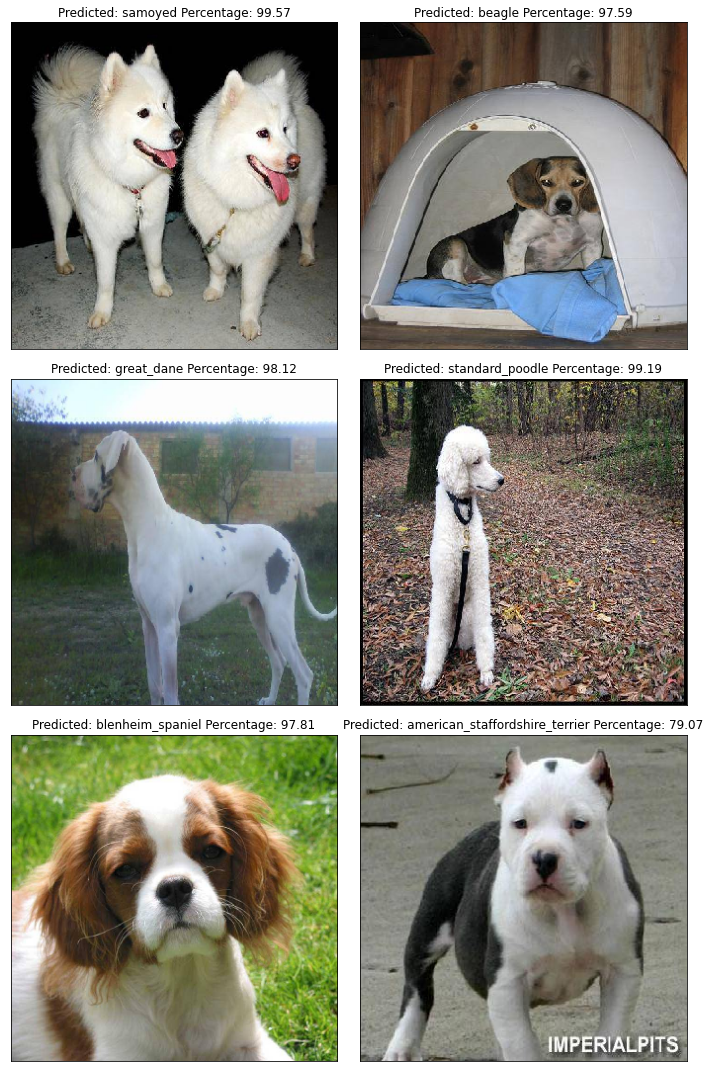

In [23]:
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    n=i*13 +1
    pred_label = dog_breeds[np.argmax(y_pred[n])]
    plt.imshow(test_data[n])
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Predicted: {pred_label} Percentage: {round((np.max(y_pred[n])*100),2)}")
    
plt.tight_layout(h_pad=1.0)
plt.show()